# 🦾🤖 Testing the robustness of ✨XLuminA ✨: featuring the optical telescope with different levels of experimental imperfections

This notebook is a step-by-step guide for testing the robustness of our framework when experimental conditions such as misalignment, noise and imperfections are included in the optical setup. 

We will set-up two versions of the 4f-system (optical telescope):

1. The baseline: using a pair of lenses such that the magnification is 2X.

2. The discovered solution presented in our paper. 

In [1]:
import os
import sys

# Setting the path for XLuminA modules:
current_path = os.path.abspath(os.path.join('..'))
module_path = os.path.join(current_path)

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from xlumina.__init__ import um, nm, cm, mm, radians
from xlumina.wave_optics import *
from xlumina.optical_elements import lens, SLM, shake_setup
from xlumina.toolbox import space, image_to_binary_mask, draw_sSLM, wrap_phase
import jax.numpy as jnp
from jax import random

### System specs (space and light source)

In [3]:
""" - System characteristics - """
sensor_lateral_size = 1024  # Resolution
wavelength = 632.8*nm
x_total = 1500*um # Space dimension
x, y = space(x_total, sensor_lateral_size)

""" - Define the light source - """
w0 = (1200*um , 1200*um)
gb = LightSource(x, y, wavelength)
gb.gaussian_beam(w0=w0, E0=1)

### Define the input mask (Max Planck Society logo)

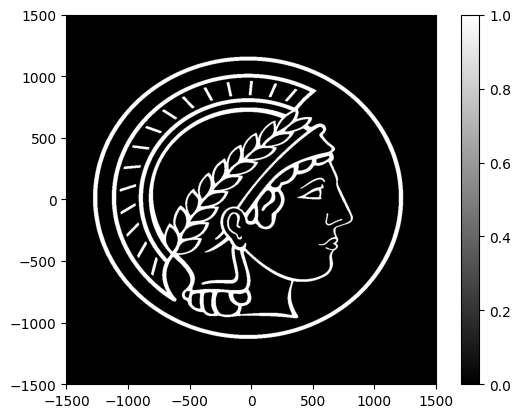

In [4]:
filename = 'MPI_logo.png'
MPI_mask = image_to_binary_mask(filename, x, y, normalize=True, invert=True, threshold=0.5)

# Visualize the mask:
plt.imshow(MPI_mask, cmap = 'gray', extent=[x[0], x[-1], y[0], y[-1]], origin='lower')
plt.colorbar()

### Define the noise levels *(using shake_setup in optical_elements.py)*:

**Low, Mild, High and All noise levels are available *(w/ or w/o 8-bit discretization for SLMs)*:**

   1. Low: 

       -  Misalignment is of 0.01 to 0.05 mm

       - Imperfections in the SLMs and WPs are of 0.01 to 0.05 rads

   2. Mild: 

       -  Misalignment is of 0.05 to 0.5 mm

       - Imperfections in the SLMs are of 0.05 to 0.5 rads

   3. High: 

       -  Misalignment is of 0.05 to 0.1 mm

       - Imperfections in the SLMs are of 0.5 to 1 rads
    
   4. All: 

        -  Misalignment is of 0.01 to 0.1 mm
        - Imperfections in the SLMs are of 0.01 to 1 rads

In [5]:
seed = np.random.randint(9999) # generate random seed

In [6]:
key = random.PRNGKey(seed) # generate key

In [7]:
# Set NS (noise settings) dictionary:
# In our setup we have 2 SLMs (i.e., which is equivalent to 1 super-SLM), 3 distances and 0 waveplates.
NS = {'n_tables': 1, # Number of optical tables to compute in parallel
      'number of distances': 3,
      'number of sSLM': 1, 
      'number of wps': 0,
      'level': 'low'} # Noise level

In [11]:
#random_noise_distances, random_noise_slms, _, _, _, _ = shake_setup(key, sensor_lateral_size, NS)
NS['noise_level'] = 'low'
NS['discretize'] = False

random_noise_distances, random_noise_slms, _, _, _, _ = shake_setup(key, sensor_lateral_size, NS)

print(random_noise_distances)
print(random_noise_slms)

[28.8465498  12.0998569  10.75144845]
[[[-0.04180742  0.01569655  0.04061627 ...  0.04896134 -0.01547571
   -0.01969495]
  [-0.03213229  0.03572007 -0.01423063 ... -0.02661428 -0.03209581
    0.02370064]
  [-0.03740202  0.04110697 -0.04062264 ... -0.04034629 -0.02190607
    0.03248548]
  ...
  [ 0.01664328  0.0420587  -0.02746926 ... -0.04627483  0.02339677
    0.03204735]
  [-0.01021377 -0.01733577 -0.03942255 ... -0.03548104  0.0186988
   -0.0479522 ]
  [-0.03550531  0.03656321  0.0120908  ... -0.03932074 -0.02096136
   -0.03106228]]

 [[-0.04774033 -0.03550954  0.01851176 ... -0.03107043 -0.02079683
    0.03601207]
  [-0.02317972 -0.02434978  0.03324856 ... -0.0460928   0.0331681
    0.03820118]
  [-0.02617218 -0.02392135  0.03988299 ... -0.04777134 -0.04185927
   -0.0233978 ]
  ...
  [-0.01613799  0.02311315  0.04111059 ... -0.02849792  0.0362545
    0.04124009]
  [ 0.01124241 -0.02910138  0.03433289 ... -0.01386384 -0.03255427
   -0.04473333]
  [ 0.03978785 -0.01897938 -0.01551922

### Define the optical setup:

In [12]:
def baseline_4f_system(light_source, input_mask, parameters, noise_distance, noise_phase):
    """
    Define an optical table with a 4f system composed by 2 SLMs, noise sources in the SLMs and misalignment. 

    [Distances must be input in cm]

    Parameters:
        light_source (LightSource)
        input_mask (jnp.array): Mask to be magnified. 
        parameters (list): Optical parameters [distance_1, distance_2, distance_3, slm_1, slm_2].
        noise_distance (list): random misalignment for [distance_1, distance_2, distance_3]
        noise_phase (list): random noise for slm phase [lens_1, lens_2]

    Returns the detected light. 
    """
    shape = jnp.shape(x)[0]

    # Apply mask to light source:
    light_source.field = input_mask * light_source.field
    
    """ Stage 0 """
    # Propagate light from mask. Here we add misalignment (noise_distance).
    light_stage0, _ = light_source.RS_propagation(z=parameters[0]*cm + noise_distance[0])
    
    """ Stage 1 """
    # Feed SLM_1 with parameters[2] (with noise noise_phase) and apply the mask to the forward beam
    modulated_slm1, _ = SLM(light_stage0, parameters[3] + noise_phase[0], shape)

    # Propagate the SLM_1 output beam to another distance z with misalignment (noise_distance)
    light_stage1, _ = modulated_slm1.RS_propagation(z=parameters[1]*cm + noise_distance[1])

    """ Stage 2 """
    # Feed SLM_2 with parameters[4] (with noise noise_phase) and apply the mask to the forward beam
    modulated_slm2, _ = SLM(light_stage1, parameters[4] + noise_phase[0], shape)

    # Propagate the SLM_2 output beam to another distance z with misalignment (noise_distance)
    detected_light, _ = modulated_slm2.RS_propagation(z=parameters[2]*cm + noise_distance[2])

    return detected_light

### 1. Compute baseline:

#### Define the baseline setup parameters: 

The 4f system consists of (--d--> stands for propagation a distance 'd'):

        Light source * mask --d1--> lens_1 --d2--> lens_2 --d3--> Detector,

with a pair of lenses with focal length $f_1/f_2$ = 2 (for 2X magnification) and $d_2 = d_1+d_3$.



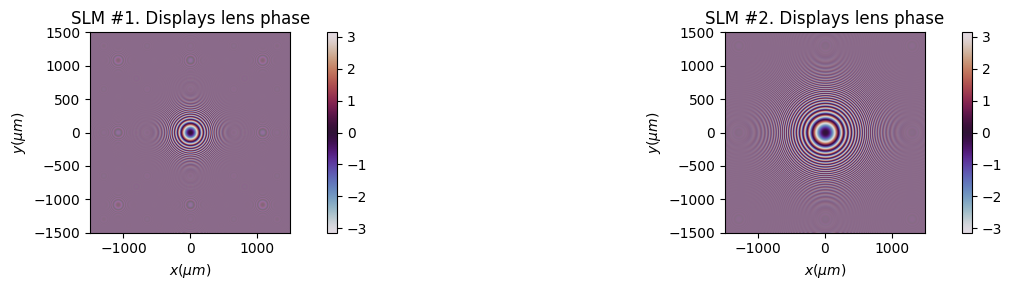

In [13]:
focal_1 = 15*mm
focal_2 = 30*mm

_, lens1 = lens(gb, radius=(5/2*mm, 5/2*mm), focal=(focal_1, focal_1))
_, lens2 = lens(gb, radius=(5/2*mm, 5/2*mm), focal=(focal_2, focal_2))

d1 = 1.5 # cm
d2 = 4.5 # cm
d3 = 3.0 # cm

# Build baseline parameters list with [distance_1, distance_2, distance_3, lens_1, lens_2].
# We extract the phase from lens objects as we are using SLM instead of lens objects as we can include noise sources. 
baseline_params = [d1, d2, d3, jnp.angle(lens1), jnp.angle(lens2)]

# Visualize the phase masks applied to the SLMs:
draw_sSLM(wrap_phase(baseline_params[3]), wrap_phase(baseline_params[4]), extent = [x[0], x[-1], y[0], y[-1]], extra_title='Displays lens phase')


#### Apply setup with different noise levels:

Time taken to perform one RS propagation (in seconds): 1.4353
Time taken to perform one RS propagation (in seconds): 0.0168
Time taken to perform one RS propagation (in seconds): 1.0276


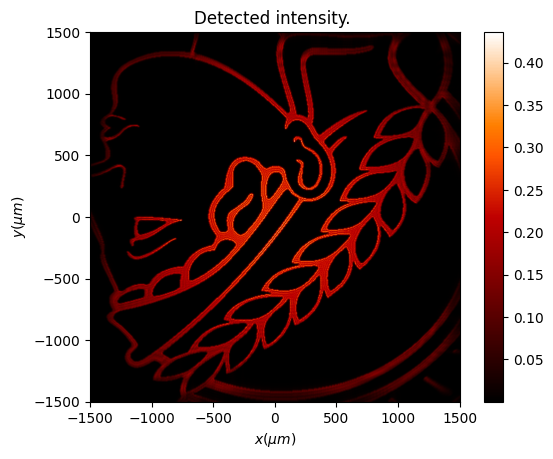

In [14]:
# 1. 'Low' level, already defined:
baseline_light = baseline_4f_system(gb, MPI_mask, baseline_params, random_noise_distances, random_noise_slms)

# Visualize detected light:
baseline_light.draw(xlim=(x[0], x[-1]), ylim=(y[0], y[-1]), kind='Intensity')

Time taken to perform one RS propagation (in seconds): 0.2343
Time taken to perform one RS propagation (in seconds): 1.2386
Time taken to perform one RS propagation (in seconds): 1.1413


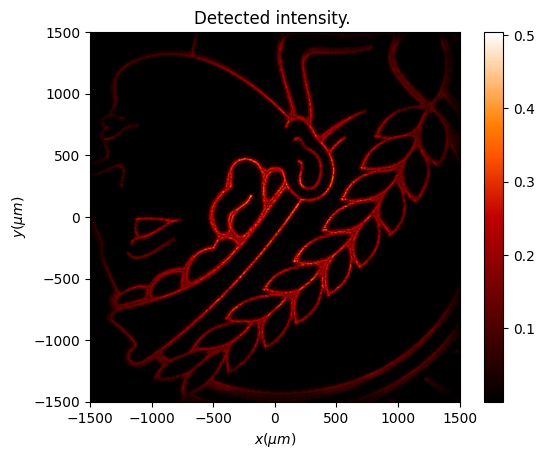

In [17]:
# 2. 'Mild' level:
NS['noise_level'] = 'mild'

random_noise_distances, random_noise_slms, _, _, _, _ = shake_setup(key, sensor_lateral_size, NS)
baseline_light = baseline_4f_system(gb, MPI_mask, baseline_params, random_noise_distances, random_noise_slms)

# Visualize detected light:
baseline_light.draw(xlim=(x[0], x[-1]), ylim=(y[0], y[-1]), kind='Intensity')

Time taken to perform one RS propagation (in seconds): 0.0232
Time taken to perform one RS propagation (in seconds): 0.9848
Time taken to perform one RS propagation (in seconds): 0.9528


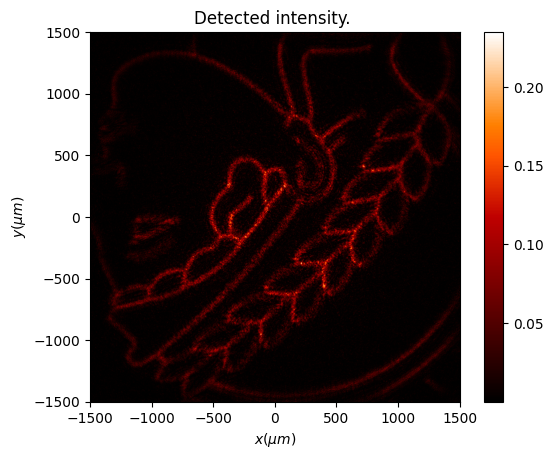

In [18]:
# 3. 'High' level:
NS['noise_level'] = 'high'
NS['discretize'] = False

random_noise_distances, random_noise_slms, _, _, _, _ = shake_setup(key, sensor_lateral_size, NS)
baseline_light = baseline_4f_system(gb, MPI_mask, baseline_params, random_noise_distances, random_noise_slms)

# Visualize detected light:
baseline_light.draw(xlim=(x[0], x[-1]), ylim=(y[0], y[-1]), kind='Intensity')

Time taken to perform one RS propagation (in seconds): 0.2145
Time taken to perform one RS propagation (in seconds): 1.2185
Time taken to perform one RS propagation (in seconds): 1.2335


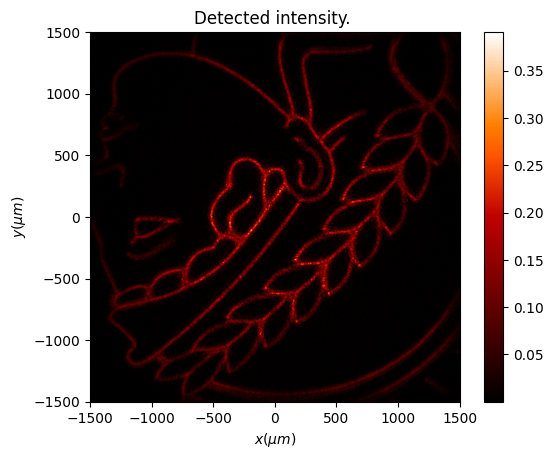

In [20]:
# 4. 'All' level:
NS['noise_level'] = 'all'

random_noise_distances, random_noise_slms, _, _, _, _ = shake_setup(key, sensor_lateral_size, NS)
baseline_light = baseline_4f_system(gb, MPI_mask, baseline_params, random_noise_distances, random_noise_slms)

# Visualize detected light:
baseline_light.draw(xlim=(x[0], x[-1]), ylim=(y[0], y[-1]), kind='Intensity')

### 2. Compute discovered solution:

In [21]:
# Open file with optical parameters
filename = "discovered_solution_4f_system.npy"
data = np.load(filename, allow_pickle=True)
optical_parameters = data.item()["Discovered parameters"]

Distance 1: 11.344653129577637 cm, distance 2: 6.664485931396484 cm and distance 3: 8.7441987991333 cm


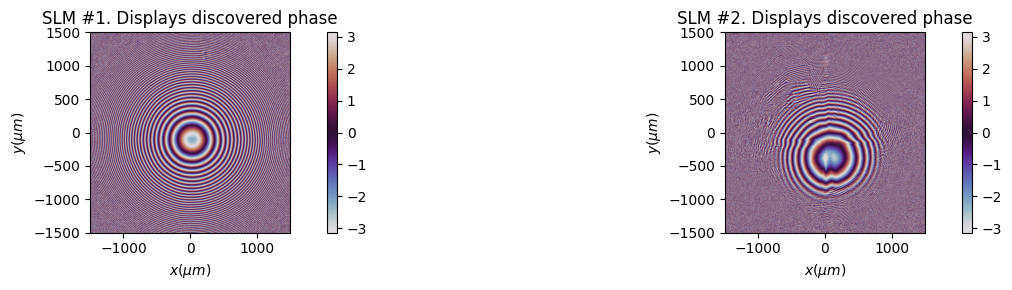

In [22]:
# Visualize the discovered phase masks applied to the SLMs:
print(f"Distance 1: {optical_parameters[0]} cm, distance 2: {optical_parameters[1]} cm and distance 3: {optical_parameters[2]} cm")
draw_sSLM(wrap_phase(optical_parameters[3]), wrap_phase(optical_parameters[4]), extent = [x[0], x[-1], y[0], y[-1]], extra_title='Displays discovered phase')

#### Apply setup with different noise levels:

Time taken to perform one RS propagation (in seconds): 0.0074
Time taken to perform one RS propagation (in seconds): 1.0058
Time taken to perform one RS propagation (in seconds): 1.2102


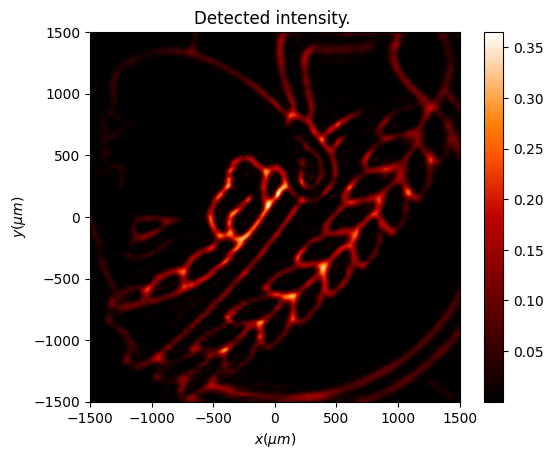

In [24]:
# 1. 'Low' level:
NS['noise_level'] = 'low'
NS['discretize'] = False

random_noise_distances, random_noise_slms, _, _, _, _ = shake_setup(key, sensor_lateral_size, NS)
baseline_light = baseline_4f_system(gb, MPI_mask, optical_parameters, random_noise_distances, random_noise_slms)

# Visualize detected light:
baseline_light.draw(xlim=(x[0], x[-1]), ylim=(y[0], y[-1]), kind='Intensity')

Time taken to perform one RS propagation (in seconds): 0.2418
Time taken to perform one RS propagation (in seconds): 1.0402
Time taken to perform one RS propagation (in seconds): 1.3254


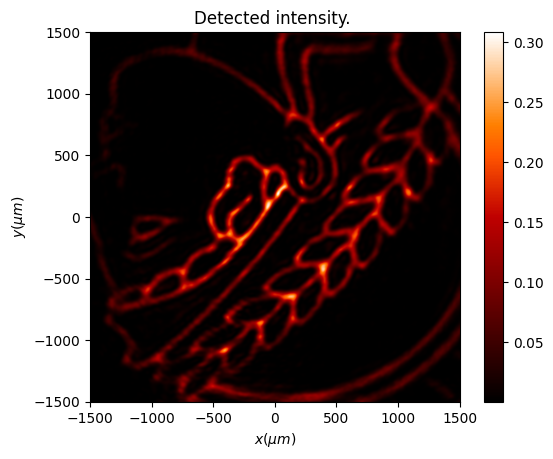

In [26]:
# 2. 'Mild' level:
NS['noise_level'] = 'mild'
NS['discretize'] = False

random_noise_distances, random_noise_slms, _, _, _, _ = shake_setup(key, sensor_lateral_size, NS)
baseline_light = baseline_4f_system(gb, MPI_mask, optical_parameters, random_noise_distances, random_noise_slms)

# Visualize detected light:
baseline_light.draw(xlim=(x[0], x[-1]), ylim=(y[0], y[-1]), kind='Intensity')

Time taken to perform one RS propagation (in seconds): 0.3132
Time taken to perform one RS propagation (in seconds): 1.5639
Time taken to perform one RS propagation (in seconds): 1.1880


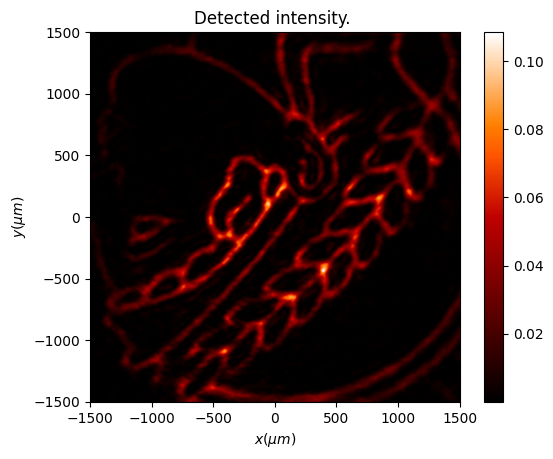

In [27]:
# 3. 'High' level:
NS['noise_level'] = 'high'
NS['discretize'] = False

random_noise_distances, random_noise_slms, _, _, _, _ = shake_setup(key, sensor_lateral_size, NS)
baseline_light = baseline_4f_system(gb, MPI_mask, optical_parameters, random_noise_distances, random_noise_slms)

# Visualize detected light:
baseline_light.draw(xlim=(x[0], x[-1]), ylim=(y[0], y[-1]), kind='Intensity')

Time taken to perform one RS propagation (in seconds): 0.2851
Time taken to perform one RS propagation (in seconds): 1.1838
Time taken to perform one RS propagation (in seconds): 1.2117


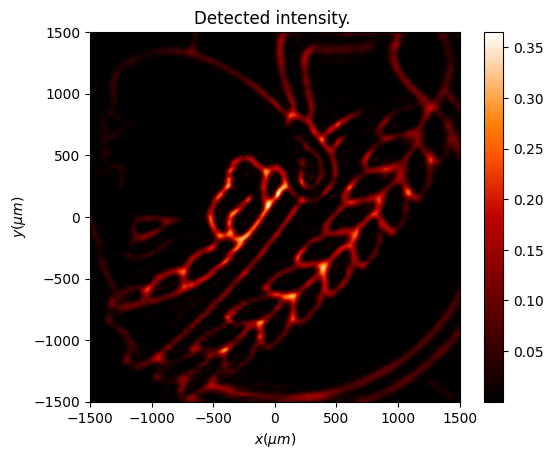

In [28]:
# 1. 'Low' level:
NS['noise_level'] = 'low'
NS['discretize'] = False

random_noise_distances, random_noise_slms, _, _, _, _ = shake_setup(key, sensor_lateral_size, NS)
baseline_light = baseline_4f_system(gb, MPI_mask, optical_parameters, random_noise_distances, random_noise_slms)

# Visualize detected light:
baseline_light.draw(xlim=(x[0], x[-1]), ylim=(y[0], y[-1]), kind='Intensity')

Time taken to perform one RS propagation (in seconds): 0.0939
Time taken to perform one RS propagation (in seconds): 1.0562
Time taken to perform one RS propagation (in seconds): 1.1522


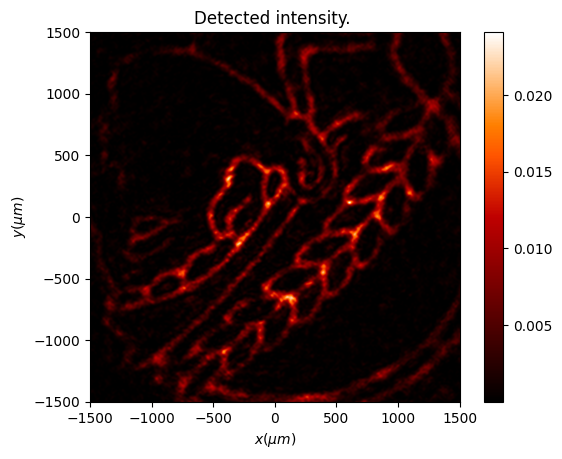

In [29]:
# 5. 'High' level 8-bit discretized:
NS['noise_level'] = 'high'
NS['discretize'] = True

random_noise_distances, random_noise_slms, _, _, _, _ = shake_setup(key, sensor_lateral_size, NS)
baseline_light = baseline_4f_system(gb, MPI_mask, optical_parameters, random_noise_distances, random_noise_slms)

# Visualize detected light:
baseline_light.draw(xlim=(x[0], x[-1]), ylim=(y[0], y[-1]), kind='Intensity')